**Instructions**

Run the note book to see the evaluation on the pre-trained model, alternatively train a new model  
This code was adapted from: https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S where marked "(see ref above)", otherwise it is original.

In [1]:
#import libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()

In [3]:
#import cleaned data
df = pd.read_csv('text_emotion_cleaned.csv', dtype={'tweet_without_stopwords': str})
df['content']=df['tweet_without_stopwords'].astype('str')
df['label'] = pd.factorize(df['sentiment'])[0].astype(np.uint16)
df_train = df.iloc[:32000]
df_valid = df.iloc[32000:36000]
df_test = df.iloc[36000:40000]

#create list of class names
class_names = list(df['sentiment'].unique())

In [4]:
#create tokeniser using 'bert_base_cased' mode
#(see ref above)
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, truncation=True)

In [5]:
#define max length (each input must be standard). 
#Most tweets are less than 50 words. We can choose more, but it slows the training for little accuracy benefit
MAX_LEN = 50

In [6]:
#define Pytorch dataset class
#(see ref above)
class FigureEight(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweets = str(self.tweets[item])
    target = self.targets[item]

    #encode the tweets into tokens
    encoding = self.tokenizer.encode_plus(
      tweets,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    truncation=True) 

    return {
      'tweet_text': tweets,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [7]:
#define helper functiont to create dataloader
#(see ref above)
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FigureEight(
    tweets=df.content.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

    return DataLoader(
    ds,
    batch_size=batch_size, shuffle=True)  #num_workers=4

In [8]:
BATCH_SIZE =  64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [9]:
#define model
#(see ref above)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
#create transformer network
#(see ref above)

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3) # dropout layer
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) #linear layer
  
  #forward function includes pooling
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False 
    )
   
    output = self.drop(pooled_output)
    return self.out(output)

In [11]:
#create model
model = SentimentClassifier(len(class_names))
model = model.to(device)
model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [12]:
#load pretrained model
model.load_state_dict(torch.load('BERT-weights.bin')) 
model = model.to(device)
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

### Training

In [13]:
#(see ref above)
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [14]:
##uncomment to use training function
##(see ref above)

# def train_epoch(
#   model, 
#   data_loader, 
#   loss_fn, 
#   optimizer, 
#   device, 
#   scheduler, 
#   n_examples
# ):
#   model = model.train()

#   losses = []
#   correct_predictions = 0
  
#   for d in data_loader:
#     input_ids = d["input_ids"].to(device)
#     attention_mask = d["attention_mask"].to(device)
#     targets = d["targets"].to(device)

#     outputs = model(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )

#     _, preds = torch.max(outputs, dim=1)
#     loss = loss_fn(outputs, targets)

#     correct_predictions += torch.sum(preds == targets)
#     losses.append(loss.item())

#     loss.backward()
#     nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
#     optimizer.step()
#     scheduler.step()
#     optimizer.zero_grad()

#   return correct_predictions.double() / n_examples, np.mean(losses)

In [15]:
#define evaluation function
#(see ref above)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
# %%time
##training cell, uncomment to train
##(see ref above)



# history = defaultdict(list)
# best_accuracy = 91

# for epoch in tqdm(range(EPOCHS)):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,    
#     loss_fn, 
#     optimizer, 
#     device, 
#     scheduler, 
#     len(df_train)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn, 
#     device, 
#     len(df_valid)
#   )

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if train_acc > best_accuracy: ##save best model
#     torch.save(model.state_dict(), 'best_model.bin')
#     best_accuracy = train_acc

In [17]:
# load pretrained loss and accuracy histories (or ignore if training new model)
train_loss=np.load('my_BERT26SEPThistories.npy')[0]
train_acc=np.load('my_BERT26SEPThistories.npy')[1]
valid_loss=np.load('my_BERT26SEPThistories.npy')[2]
valid_acc=np.load('my_BERT26SEPThistories.npy')[3]

In [18]:
##uncomment to set up plots for newly trained model
# train_loss = np.array(history['train_loss'])
# train_acc = np.array(([x.detach().cpu().numpy().item() for x in history['train_acc']]))
# valid_loss = np.array(history['val_loss'])
# valid_acc = np.array(([x.detach().cpu().numpy().item() for x in history['val_acc']]))

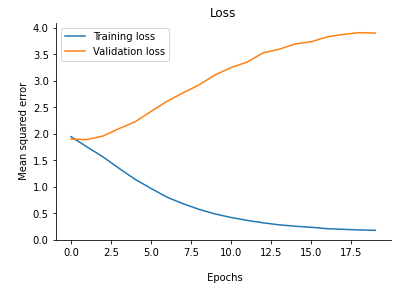

In [19]:
# plot loss
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.xlabel('\n Epochs')
plt.ylabel('\n Mean squared error')
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.title('Loss')
plt.legend()

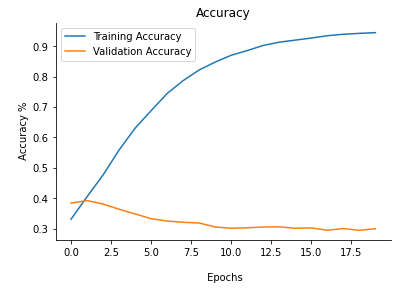

In [20]:
#plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('\n Epochs')
plt.ylabel('\n Accuracy %')
plt.title('Accuracy')
plt.legend()

## Evaluation


In [21]:
#get accuracy on testset
#(see ref above)
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.30325

In [22]:
#get accuracy on training set
#(see ref above)
##NB due to the training function reporting accuracy before printing accuracy...
##...this is different from the last accuracy in the history above.
train_acc, _ = eval_model(
  model,
  train_data_loader,
  loss_fn,
  device,
  len(df_train)
)

train_acc.item()

0.9791562500000001

In [23]:
#helper function to get predictions
#(see ref above)
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [24]:
#extract predictions on the training set
#(see ref above)
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  train_data_loader
)

In [25]:
#create evaluation report on the training set
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
cr_df = pd.DataFrame(report)
del cr_df['weighted avg']
del cr_df['accuracy']
del cr_df['macro avg']
cr_df.sort_values(by='f1-score', axis=1, ascending=False, inplace=True)
cr_df = cr_df.rename(index={'f1-score': 'F1 Score', 'recall': 'Recall', 'precision': 'Precision'})
cr_df.reindex(['F1 Score','Precision','Recall','Support']).round(3)
cr_df

,fun,worry,sadness,hate,happiness,love,surprise,relief,neutral,enthusiasm,empty,boredom,anger
Precision,0.988719,0.987390,0.985427,0.981967,0.985928,0.979472,0.984330,0.983784,0.960551,0.985321,0.975573,0.891566,0.941860
Recall,0.983962,0.983772,0.982603,0.985197,0.979324,0.979062,0.973035,0.966372,0.986156,0.947090,0.914163,0.919255,0.826531
F1 Score,0.986334,0.985578,0.984013,0.983580,0.982615,0.979267,0.978650,0.975000,0.973185,0.965827,0.943870,0.905199,0.880435
support,1247.000000,7641.000000,4886.000000,1216.000000,3434.000000,2388.000000,1743.000000,1130.000000,6790.000000,567.000000,699.000000,161.000000,98.000000


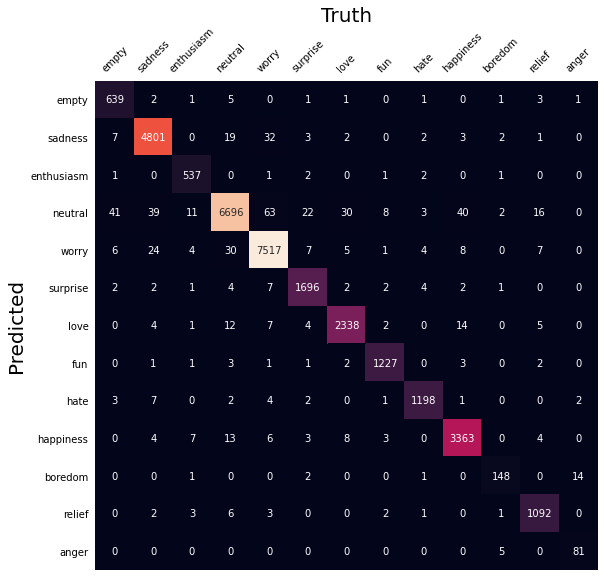

In [26]:
#define confusion matrix plot function and show training set confusion matrix

def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(9,9))
  hmap = sns.heatmap(confusion_matrix, annot=True, cbar=False, fmt='d', linecolor='black')#cmap="Blues"
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=45)
  hmap.xaxis.set_label_position('top') 
  hmap.xaxis.tick_top()
  hmap.tick_params(left=False, bottom=False, top=False)
  plt.ylabel('Predicted', size=20)
  plt.xlabel('Truth', size=20)
#   plt.title('Testset Confusion Matrix', loc='left');

#(see ref above)
cm = confusion_matrix(y_test, y_pred).T
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [27]:
#extract predictions on the test set
#(see ref above)
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [28]:
#create evaluation report on the testset
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
cr_df = pd.DataFrame(report)
del cr_df['weighted avg']
del cr_df['accuracy']
del cr_df['macro avg']
cr_df.sort_values(by='f1-score', axis=1, ascending=False, inplace=True)
cr_df = cr_df.rename(index={'f1-score': 'F1 Score', 'recall': 'Recall', 'precision': 'Precision'})
cr_df.reindex(['F1 Score','Precision','Recall','Support']).round(3)
cr_df

C:\Users\martin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\martin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\martin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,love,neutral,happiness,hate,worry,sadness,fun,relief,surprise,enthusiasm,empty,boredom,anger
Precision,0.427989,0.417341,0.386700,0.285714,0.200717,0.108491,0.124000,0.120000,0.096257,0.056604,0.0,0.0,0.0
Recall,0.469449,0.380802,0.347345,0.203390,0.259861,0.172932,0.120623,0.106061,0.081448,0.058824,0.0,0.0,0.0
F1 Score,0.447761,0.398235,0.365967,0.237624,0.226491,0.133333,0.122288,0.112601,0.088235,0.057692,0.0,0.0,0.0
support,671.000000,948.000000,904.000000,59.000000,431.000000,133.000000,257.000000,198.000000,221.000000,102.000000,65.0,9.0,2.0


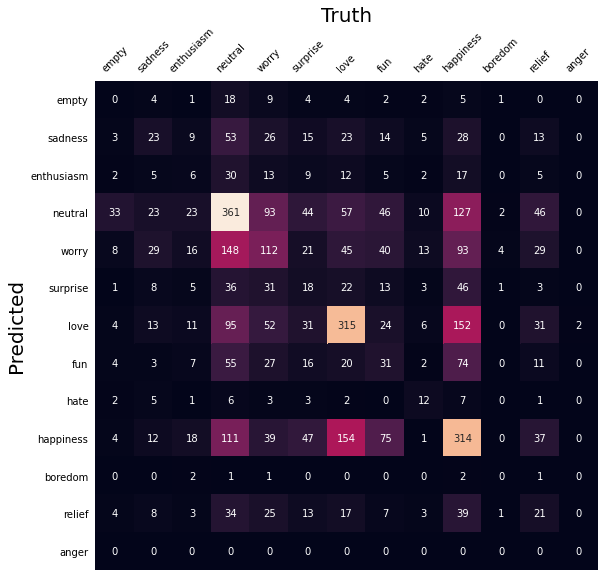

In [29]:
#show testset confusion matrix
#(see ref above)
cm = confusion_matrix(y_test, y_pred).T
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)